In [0]:
%tensorflow_version 2.x

In [0]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_datasets as tfds

%matplotlib inline

In [0]:
tfds.disable_progress_bar()
(train_ds, test_ds), ds_info = tfds.load(
    'cats_vs_dogs',
    as_supervised=True,
    with_info=True,
    split=['train[:90%]', 'train[90%:]']
)

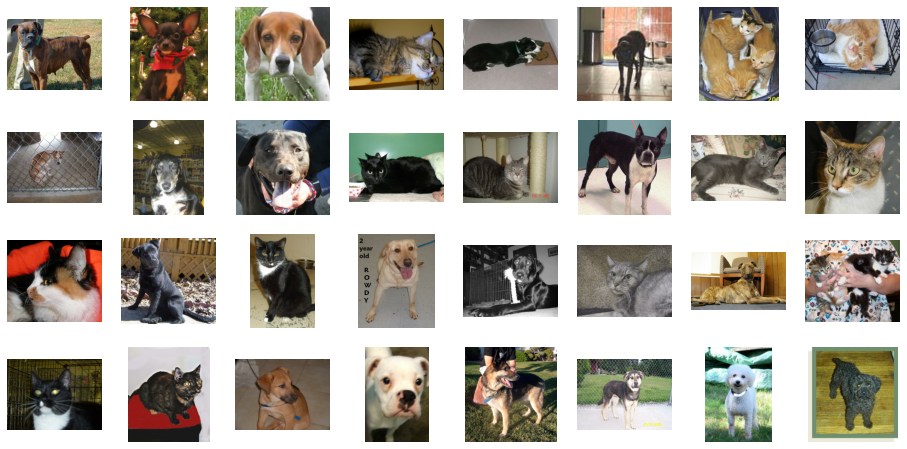

In [19]:
some_samples = [x[0] for x in iter(train_ds.take(32))]

fig = plt.figure(figsize=(16, 8))
for j in range(len(some_samples)):
    ax = fig.add_subplot(4, 8, j+1)
    ax.imshow(some_samples[j])
    plt.axis('off')
plt.show()

In [0]:
IMP_SIZE = 160
NUM_EPOCHS = 10
BATCH_SIZE = 32

def prepare(img, label):
    img = tf.cast(img, tf.float32) / 127. - 1. # не от 0 до 1 (/255.), f jn -1 lj 1
    return tf.image.resize(img, (IMP_SIZE, IMP_SIZE)), label

train_ds = train_ds.shuffle(buffer_size=1000)
train_ds = train_ds.map(prepare)
train_ds = train_ds.batch(BATCH_SIZE, drop_remainder=True)

test_ds = test_ds.shuffle(buffer_size=1000)
test_ds = test_ds.map(prepare)
test_ds = test_ds.batch(128, drop_remainder=True)

In [21]:
if 0: # Обучение модели с нуля

    EXP_NAME = 'scratch'
    base_model = tf.keras.applications.MobileNetV2(
        input_shape=(IMP_SIZE, IMP_SIZE, 3),
        include_top=False, # не включать последний слой классификации (top)
        weights=None,
    )
    base_model.trainable = True

else: # Transfer Learning

    EXP_NAME = 'transfer'
    base_model = tf.keras.applications.MobileNetV2(
        input_shape=(IMP_SIZE, IMP_SIZE, 3),
        include_top=False,
        weights='imagenet',
    )
    base_model.trainable = True # Fine Tuning весов предобученной модели   
    # base_model.trainable = False # заморозка весов предобученной модели 

model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

9412608/9406464 [==============================] - 0s 0us/step


In [0]:
LEARNING_RATE = 0.0001
optimizer = tf.keras.optimizers.RMSprop(lr=LEARNING_RATE)

model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

tensorboard_callbacks = tf.keras.callbacks.TensorBoard(
    log_dir='logs/model_with_wd',
    write_graph=False, update_freq=100, profile_batch=0)

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_160 (Model) (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 2,225,153
Non-trainable params: 34,112
_________________________________________________________________


In [24]:
%%time

history = model.fit(
    train_ds,
    epochs=NUM_EPOCHS,
    validation_set=test_ds,
    callbacks=[tensorboard_callbacks]
)

Epoch 1/10
654/654 [==============================] - 130s 199ms/step - loss: 0.0851 - accuracy: 0.9688
Epoch 2/10
654/654 [==============================] - 130s 199ms/step - loss: 0.0262 - accuracy: 0.9911
Epoch 3/10
654/654 [==============================] - 131s 200ms/step - loss: 0.0157 - accuracy: 0.9948
Epoch 4/10
654/654 [==============================] - 130s 199ms/step - loss: 0.0113 - accuracy: 0.9961
Epoch 5/10
654/654 [==============================] - 130s 198ms/step - loss: 0.0071 - accuracy: 0.9979
Epoch 6/10
654/654 [==============================] - 131s 201ms/step - loss: 0.0075 - accuracy: 0.9975
Epoch 7/10
654/654 [==============================] - 131s 201ms/step - loss: 0.0050 - accuracy: 0.9985
Epoch 8/10
654/654 [==============================] - 131s 201ms/step - loss: 0.0043 - accuracy: 0.9989
Epoch 9/10
654/654 [==============================] - 131s 200ms/step - loss: 0.0042 - accuracy: 0.9987
Epoch 10/10
654/654 [==============================] - 131s 201m

In [25]:
%%time

test_loss, test_accuracy = model.evaluate(test_ds)

18/18 [==============================] - 4s 230ms/step - loss: 0.0727 - accuracy: 0.9905
CPU times: user 11 s, sys: 1.33 s, total: 12.3 s
Wall time: 7.63 s


--2020-04-15 14:04:36--  https://sun3-12.userapi.com/r4KHPyIZc0auYWLEzBC2nN8thyX305HArf8qmQ/s8tuObOT_rY.jpg
Resolving sun3-12.userapi.com (sun3-12.userapi.com)... 95.142.201.66
Connecting to sun3-12.userapi.com (sun3-12.userapi.com)|95.142.201.66|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 123057 (120K) [image/jpeg]
Saving to: ‘s8tuObOT_rY.jpg’

s8tuObOT_rY.jpg     100%[===================>] 120.17K  --.-KB/s    in 0.1s    

2020-04-15 14:04:36 (821 KB/s) - ‘s8tuObOT_rY.jpg’ saved [123057/123057]



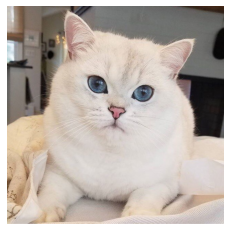

In [26]:
import imageio
from skimage.transform import resize

def prepare_img(img):
    img = img.astype(np.float32) / 255.
    img = resize(img, (IMP_SIZE, IMP_SIZE), order=3, mode='reflect', anti_aliasing=True)
    return img.astype(np.float32)

if 1:
    !wget https://sun3-12.userapi.com/r4KHPyIZc0auYWLEzBC2nN8thyX305HArf8qmQ/s8tuObOT_rY.jpg

img = imageio.imread('s8tuObOT_rY.jpg', pilmode='RGB')
plt.imshow(img)
plt.axis('off')

img = prepare_img(img)

In [27]:
pred = model(img[None, ...], training=False)
pred_label = int(pred.numpy()[0][0] > 0.5)

print('Predicted: {}'.format(ds_info.features['label'].int2str(pred_label)))

Predicted: cat
